# Bike Sharing Demand 공공자전거 수요 예측 모델

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import norm, skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.metrics import fbeta_score, make_scorer

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# 그래프 그리기 위한 matplolib
%matplotlib inline
plt.style.use('ggplot')
#폰트깨짐방지
mpl.rcParams['axes.unicode_minus']=False

## Step1. 데이터 불러오기

In [4]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
test = pd.read_csv("test.csv", parse_dates=["datetime"])

In [5]:
##데이터 형태 확인 10886개 행의 데이터와 12열
train.shape

(10886, 12)

In [6]:
## Feature 타입 확인
## season, holiday, workingday, weather 변수는 범주형 변수 int타입
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [7]:
## test데이터 형태 6493행의 9개열
test.shape

(6493, 9)

In [8]:
## train 데이터와 다르게 registered, casual, count 데이터가 없음
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [9]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
## 계절 및 시간별로 연관성을 파악하기 위해 datetime을 년, 월, 주, 일, 시간, 분, 초 단위로 쪼갬
train['year']=train["datetime"].dt.year
train['month']=train["datetime"].dt.month
train['week']=train["datetime"].dt.week
train['day']=train["datetime"].dt.day
train['hour']=train["datetime"].dt.hour
train['minute']=train["datetime"].dt.minute
train['second']=train["datetime"].dt.second

test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test['week']= test["datetime"].dt.week
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second

In [12]:
##새롭게 년 월 주 일 월 분 초 컬럼이 추가된걸 확인할 수 있음
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,week,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,52,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,52,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,52,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,52,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,52,1,4,0,0


In [13]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,week,day,hour,minute,second
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,3,20,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,20,1,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,20,2,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,20,3,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,20,4,0,0


## Step2. 데이터탐색

In [14]:
## 결측치 확인
print('=====train=====')
print(train.isnull().sum())
print('=====test=====')
print(test.isnull().sum())

=====train=====
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
week          0
day           0
hour          0
minute        0
second        0
dtype: int64
=====test=====
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
year          0
month         0
week          0
day           0
hour          0
minute        0
second        0
dtype: int64


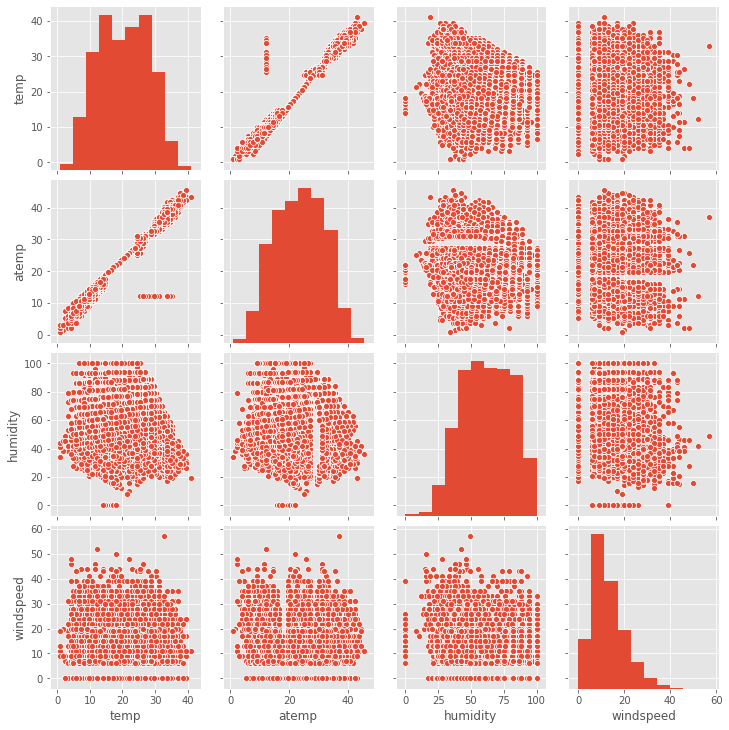

In [15]:
##범주형 데이터간의 관계도
sns.pairplot(train[['temp', 'atemp', 'humidity', 'windspeed']])

## 관계도 분석
- temp 와 atemp간의 뚜렷한 선형관계가 보인다. 다른 feature들간의 관계는 독립적인 모습
- feature간의 강한 선형관계가 있을 경우 다중공선성을 고려해야됨 해결방법으로는 변수 제거, 차분, log 변환, 정규화 등이 있다.
- 온도와 체감온도는 비슷한 의미를 가지기 때문에 변환을 통해서 다중공선성 현상을 해결하기 보다는 둘 중 하나를 삭제
  target과 더 낮은 상관계수를 가지는 변수를 제거하도록 하겠다.
- 다중공선성이란 두 변수가 일치에 가까울 정도로 관련성이 높다면 문제가 발생 할 수 있는데 이러한 것을 다중공선성의 문제라고 말함
- 다중공선성은 독립변수들 간에 강한 상관관계가 나타나서 회귀분석의 전체가정인 독립변수들 간에 상관관계가 높으면 안된다는 조건을 위배하는 경우

In [16]:
train[['temp','atemp','count']].corr(method = 'pearson')

,temp,atemp,count
temp,1.000000,0.984948,0.394454
atemp,0.984948,1.000000,0.389784
count,0.394454,0.389784,1.000000


- temp가 target과 조금 더 높은 상관계수를 가지기에 atemp를 제거

In [17]:
del train['atemp']
del test['atemp']

In [18]:
del train['casual']
del train['registered']

- 
test set에는 casual, registered가 없기 때문에 삭제 하겠다.

## Step3. Label과 변수간의 관계 파악

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Month rental amount')]

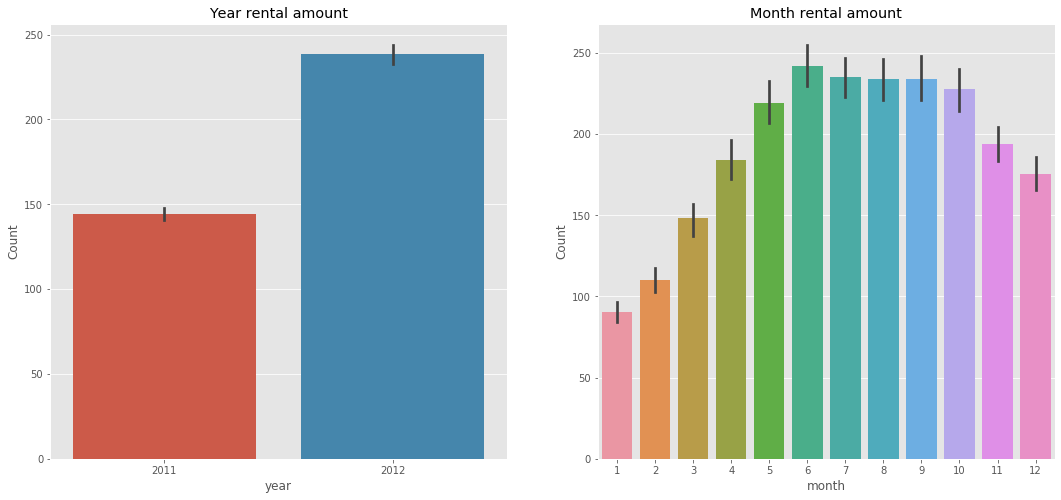

In [19]:
## 년도별, 월별 자전거 수요 카운트수 시각화
figure, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,8)
sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
ax1.set(ylabel='Count', title ="Year rental amount")
ax2.set(ylabel='Count', title ="Month rental amount")

### 위 그래프에서 알 수 있는 사실

- 연도별 그래프에서 볼 수 있는 사실로는 2011년보다 2012년에 확실히 수요가 늘었다는걸 확인할 수 있음
- 월별 그래프에서는 워싱턴의 경우 대한민국과 사계절이 비슷하기 때문에 겨울로 분류되는 12월이 봄인 3월~4월과 수치가 비슷한 것으로 나타남
- 기온 및 체감날씨를 더욱더 심화 분석한다면 해당 결과에 대한 해석이 가능할 것으로 사료


[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Hour rental amount')]

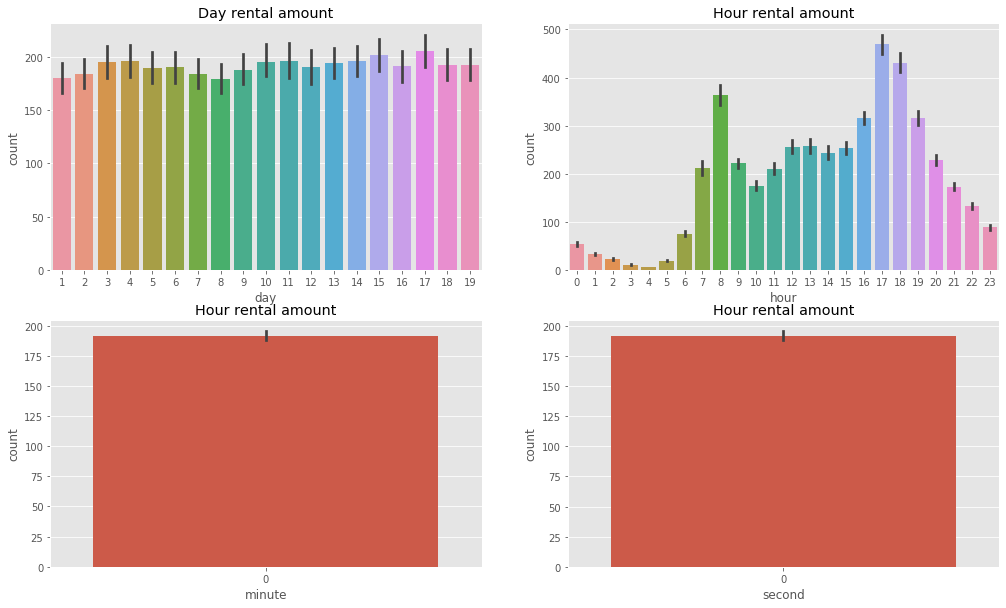

In [20]:
figure, ((ax4,ax5),(ax6,ax7)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(17,10)
sns.barplot(data=train, x="day", y="count", ax=ax4)
sns.barplot(data=train, x="hour", y="count", ax=ax5)
sns.barplot(data=train, x="minute", y="count", ax=ax6)
sns.barplot(data=train, x="second", y="count", ax=ax7)

ax4.set(ylabel='count', title ="Day rental amount")
ax5.set(ylabel='count', title ="Hour rental amount")
ax6.set(ylabel='count', title ="Hour rental amount")
ax7.set(ylabel='count', title ="Hour rental amount")

## 위 그래프에 대한 포인트
- 분과 초단위는 전혀 기록되지 않고 있음으로 의미가 없음 피쳐로 사용하지 않음 제거
- 시간별 수요에서는 아침 8시, 오후 17~18시 사이가 가장 높은 것으로 나타남 (출퇴근 시간으로 예상, 평일, 주말 구분해서 더 정확한 분석 필요)
- 일별 대여량의 경우 train에는 1일 ~ 19일까지 밖에 없음 트레인과 테스트 데이터를 나누는 기준이기 때문
- 일별 대여량을 피쳐로 선택하게 되면 과적합 현상이 일어 날 수 있으니 제외

In [21]:
del train['minute']
del train['second']
del train['day']
del test['minute']
del test['second']
del test['day']

- 일별, 분, 초 제거 컬럼

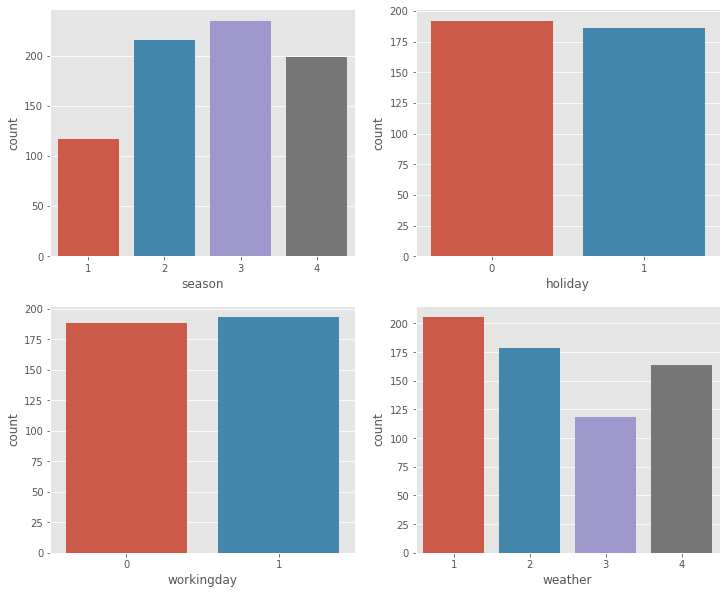

In [22]:
#계절과 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=train.groupby('season')['count'].mean().reset_index())

#휴일 여부와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='holiday',y='count',data=train.groupby('holiday')['count'].mean().reset_index())

#작업일 여부와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=train.groupby('workingday')['count'].mean().reset_index())

#날씨와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='weather',y='count',data=train.groupby('weather')['count'].mean().reset_index())

## 위 그래프 분석
- 시즌 데이터의 경우 1(봄), 2(여름), 3(가을), 4(겨울)로 나누어 보여주고 있는데 여기서 오류는 워싱턴의 경우 사계절이 한국과 비슷하다는 사실
- 따라서, 1(봄)에 1월 2월 3월이 아닌 3월,4월, 5월을 봄으로 보고 겨울의 경우 12월, 1월, 2월로 봐야될 것으로 사료되어 수정을 진행

In [23]:
def badToRight(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

train['season'] = train.month.apply(badToRight)

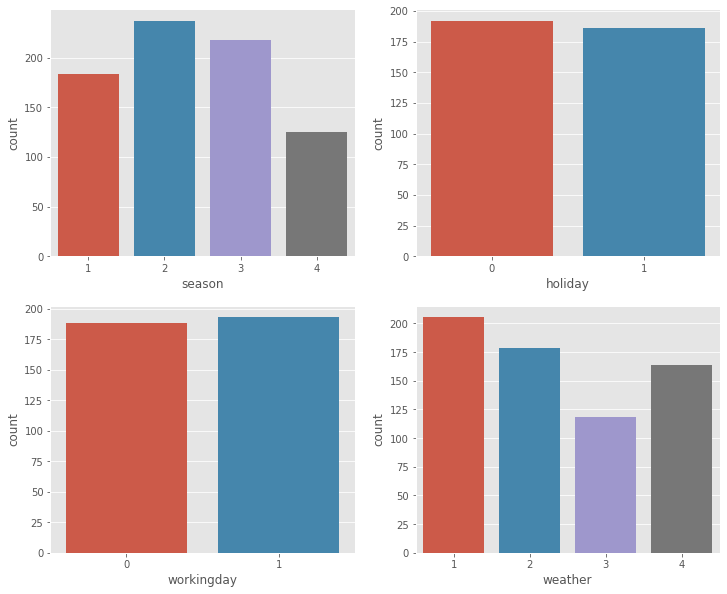

In [24]:
#계절과 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=train.groupby('season')['count'].mean().reset_index())

#휴일 여부와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='holiday',y='count',data=train.groupby('holiday')['count'].mean().reset_index())

#작업일 여부와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=train.groupby('workingday')['count'].mean().reset_index())

#날씨와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='weather',y='count',data=train.groupby('weather')['count'].mean().reset_index()) 

## 위 그래프 분석
- 처음 분석된 계절 그래프에서는 봄이 가장 낮고 가을이 높은것으로 나타났지만 수정 후 겨울이 가장 적은것으로 나타남
- 날씨의 경우 1이 맑음 2가 흐림 30이 눈또는 비 조금 4의 경우 폭우 및 폭설로 분류되며 당연히 주로 맑은 날씨에 가장 대여량이 많은 것으로 나타남
- 또한, 출근날 쉬는날에 따라 대여량의 차이는 크게 없는것으로 나타남 (전체 대여량이 아닌 시간별로 분석 진행필요)

In [25]:
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 14)

In [26]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

In [27]:
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [28]:
test["dayofweek"].value_counts()

4    958
5    928
0    928
2    924
6    923
3    918
1    914
Name: dayofweek, dtype: int64

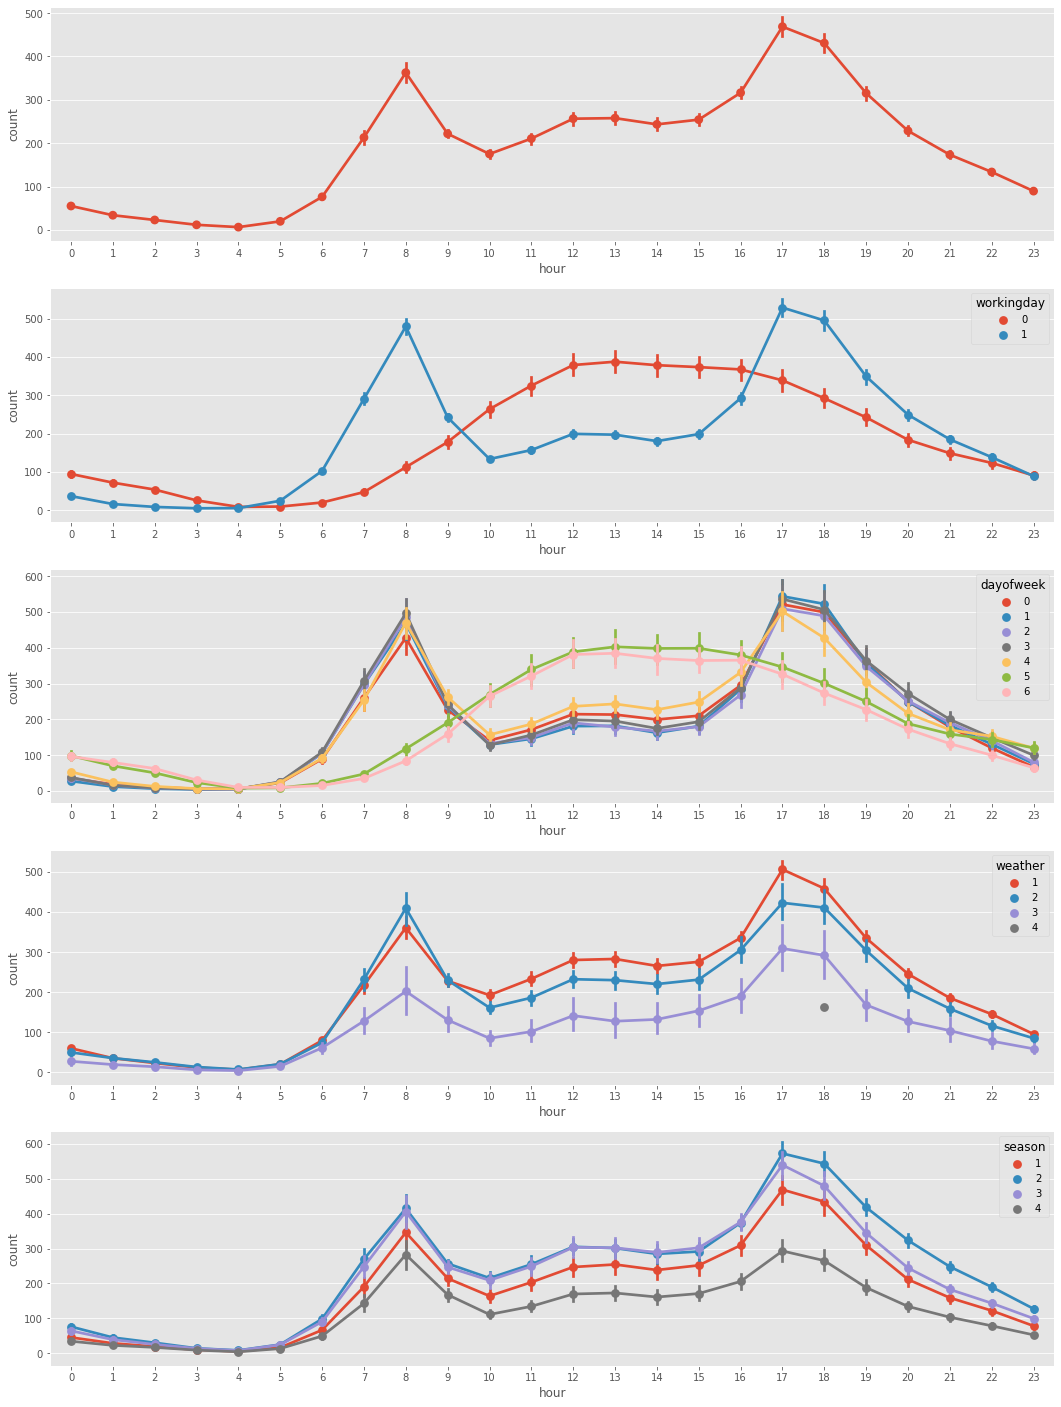

In [29]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)

sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)

sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

## 위 그래프 분석
- 2번째 그래프(0=쉬는날,1=출근날)에서 확인 가능한 사실로는 확실히 쉬는날에는 10~16시 사이에 여유로운 시간때에 대여가 많고 출근날에는
  출퇴근시간에 대여량이 가장 높은 것으로 나타남
- 3번째 그래프에서도 위와 동일하게 평일에는 출근으로 인해 출퇴근 시간때에 대여량이 많고 휴일에는 10~16시사이가 가장 많은 것으로 다시 한번 확인됨 위에서 주장한 사실이 맞아떨어짐
- 이러한 분석을 통해 Feature를 시간으로만 구성된 컬럼보다 근무일 여부가 포함된 컬럼을 선탟하는 것이 더 의미 있음
- 그리고 다른 요소들보다 요일에 따라 더 큰 차이를 나타내는 것으로 보아 요일로 구분하는 컬럼을 구성하여 선택하는 것이 더 의미 있다고 결론

In [30]:
# 월별 데이터 모아보기
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)
train["year_month"] = train["datetime"].apply(concatenate_year_month)
print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 15)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


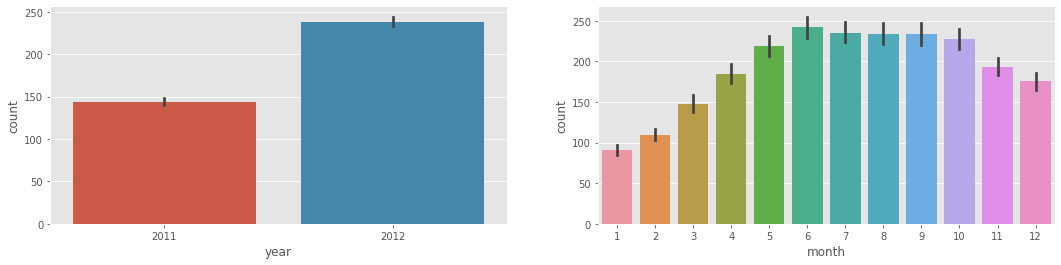

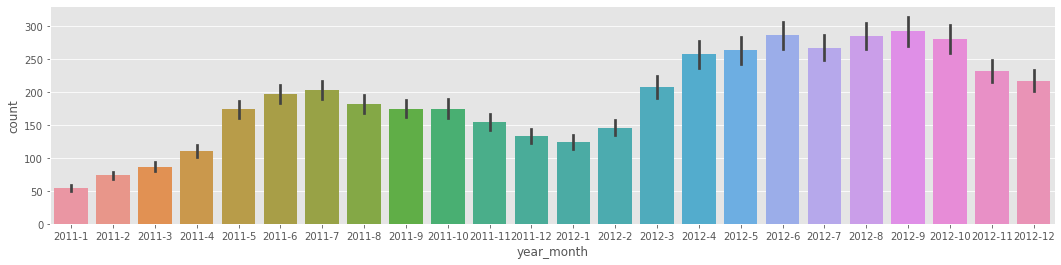

In [31]:
fig, (ax1, ax2) =plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x="year",y="count",ax=ax1)
sns.barplot(data=train, x="month",y="count",ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x="year_month",y="count",ax=ax3)

## 월별 그래프 분석
- 2011년보다 2012년 대여량이 많고 겨울보다는 여름에 대여량이 많음
- 2011년과 2012년모두 월별로 전체가 증가한 추세
- 월로만 그려진 그래프를 보았을때 언뜻보기엔 12년에 11년보다 수치가 늘어나고 다른 패턴의 형태를 띄고 있는것 처럼 보이지만 실제로는 대여량이 증가 했을뿐 사용자의 월별 이용 비율이 달라지진 않았음
- 전체 month에 따라 대여량이 달라지고 있음으로 month 데이터는 피쳐로 선택하지 않고 시즌데이터를 이용하면 해당 월별로 변화하는 대여량을 측정할 수 있음으로 month 제거

In [32]:
del train['month']
del test['month']

- month 제거

In [33]:
del train['week']
del test['week']

In [34]:
corrMatt = train[["year", "hour", "dayofweek", "workingday", "holiday", "season", "weather","windspeed","humidity","temp","count"]]
corrMatt = corrMatt.corr()
print(corrMatt)
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                year      hour  dayofweek  workingday   holiday    season  \
year        1.000000 -0.004234  -0.003785   -0.002482  0.012021  0.002976   
hour       -0.004234  1.000000  -0.002925    0.002780 -0.000354  0.003424   
dayofweek  -0.003785 -0.002925   1.000000   -0.704267 -0.191832  0.007537   
workingday -0.002482  0.002780  -0.704267    1.000000 -0.250491 -0.029800   
holiday     0.012021 -0.000354  -0.191832   -0.250491  1.000000  0.041326   
season      0.002976  0.003424   0.007537   -0.029800  0.041326  1.000000   
weather    -0.012548 -0.022740  -0.047692    0.033772 -0.007074  0.023406   
windspeed  -0.015221  0.146631  -0.024804    0.013373  0.008409 -0.052774   
humidity   -0.078606 -0.278011  -0.026507   -0.010880  0.001929  0.042525   
temp        0.061226  0.145430  -0.038466    0.029966  0.000295 -0.434241   
count       0.260403  0.400601  -0.002283    0.011594 -0.005393 -0.118785   

             weather  windspeed  humidity      temp     count  
year       

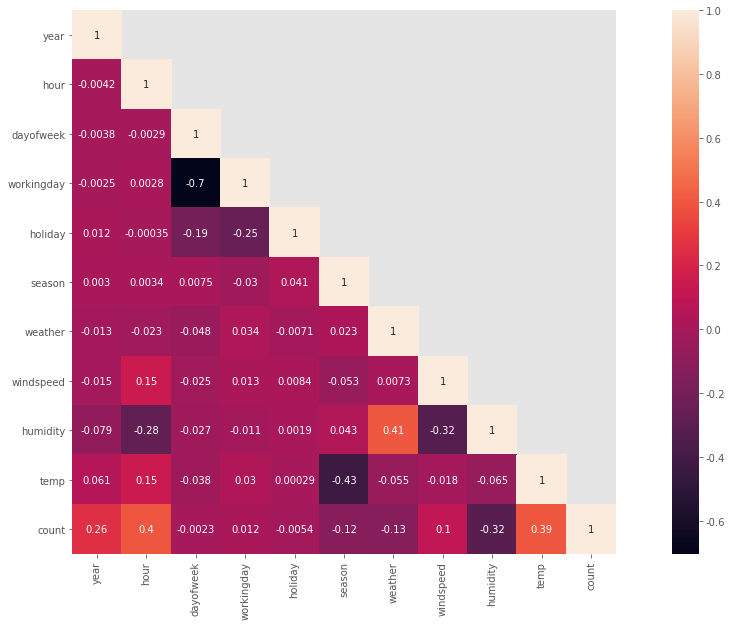

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=1, square=True,annot=True)

## 히트맵 분석
- 전체적으로 상관관계가 높지 않음 

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   humidity    10886 non-null  int64         
 7   windspeed   10886 non-null  float64       
 8   count       10886 non-null  int64         
 9   year        10886 non-null  int64         
 10  hour        10886 non-null  int64         
 11  dayofweek   10886 non-null  int64         
 12  year_month  10886 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(9), object(1)
memory usage: 1.1+ MB


In [37]:
del train['datetime']
del test['datetime']

- datetime은 모델이 학습할수 없으므로 삭제

In [38]:
del train['year_month']

- 전체 월별 데이터라면 활용을 해볼만 하겠지만 시즌으로 대체 되었고 year_month 데이터의 경우 단순 Capital bike사의 성장으로 인한 증가만을 보여줄 뿐이라서 사용자의 패턴이랑 전혀 관련이 없다고 보고 삭제

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   humidity    10886 non-null  int64  
 6   windspeed   10886 non-null  float64
 7   count       10886 non-null  int64  
 8   year        10886 non-null  int64  
 9   hour        10886 non-null  int64  
 10  dayofweek   10886 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 935.6 KB


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   humidity    6493 non-null   int64  
 6   windspeed   6493 non-null   float64
 7   year        6493 non-null   int64  
 8   hour        6493 non-null   int64  
 9   dayofweek   6493 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 507.4 KB


## 변수 선택
- 위 분석을 바탕으로 내가 생각하는 변수를 하나씩 추가하고 변경해 가면서 지속적으로 성능 업그레이드 진행

In [41]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "temp","humidity","windspeed","year","hour","dayofweek"]

In [42]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [43]:
feature_names = ["season","holiday","workingday","weather",
                             "temp","humidity","windspeed","year","hour","dayofweek"]

feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek']

In [44]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(10886, 10)


,season,holiday,workingday,weather,temp,humidity,windspeed,year,hour,dayofweek
0,4,0,0,1,9.84,81,0.0,2011,0,5
1,4,0,0,1,9.02,80,0.0,2011,1,5
2,4,0,0,1,9.02,80,0.0,2011,2,5
3,4,0,0,1,9.84,75,0.0,2011,3,5
4,4,0,0,1,9.84,75,0.0,2011,4,5


In [45]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,holiday,workingday,weather,temp,humidity,windspeed,year,hour,dayofweek
0,1,0,1,1,10.66,56,26.0027,2011,0,3
1,1,0,1,1,10.66,56,0.0000,2011,1,3
2,1,0,1,1,10.66,56,0.0000,2011,2,3
3,1,0,1,1,10.66,56,11.0014,2011,3,3
4,1,0,1,1,10.66,56,11.0014,2011,4,3


In [46]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [47]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [48]:
kfold = KFold(shuffle=True, random_state=0)
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

NameError: name 'k_fold' is not defined

NameError: name 'score' is not defined

In [50]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)

NameError: name 'k_fold' is not defined

In [54]:
from sklearn.metrics import fbeta_score, make_scorer

In [55]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

NameError: name 'predictions' is not defined

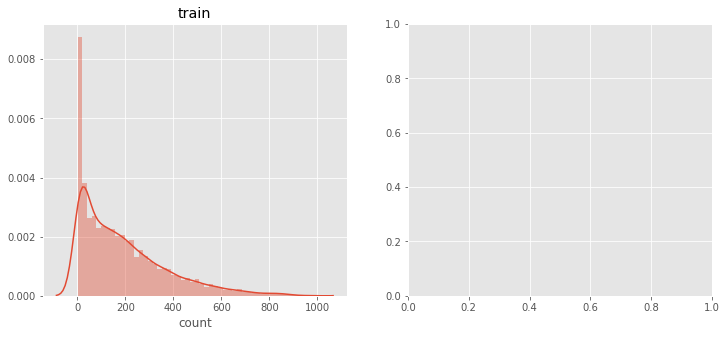

In [53]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [57]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.79
1,2011-01-20 01:00:00,5.62
2,2011-01-20 02:00:00,6.84
3,2011-01-20 03:00:00,4.40
4,2011-01-20 04:00:00,3.74


In [58]:
submission.to_csv(f"lastsubmission.csv", index=False)

- 랜덤 포레스트를 이용 887등 0.44315 Score

Text(0, 0.5, 'count')

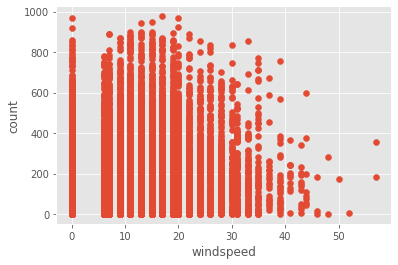

In [59]:
plt.scatter(x = train['windspeed'],
            y = train['count'])
plt.xlabel('windspeed')
plt.ylabel('count')

- windspeed와 count의 산점도를 그려 보았을 때 윈드 스피드가 0을 가지는 값이 많음
- 0~6 사이의 풍속을 가지면 풍속이 너무 낮아 측정이 안된것으로 보여짐
- 피쳐항목에서 제외시키거나 랜덤포레스트를 이용하여 0값을 변환시켜주는 방법이 있지만 이번에는 제거하는것으로 선택

In [60]:
## 상관관계도 낮은.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "temp","year","hour","dayofweek",'humidity']

In [61]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [62]:
feature_names = ["season","holiday","workingday","weather",
                             "temp","humidity","year","hour","dayofweek"]

feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'humidity',
 'year',
 'hour',
 'dayofweek']

In [63]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(10886, 9)


,season,holiday,workingday,weather,temp,humidity,year,hour,dayofweek
0,4,0,0,1,9.84,81,2011,0,5
1,4,0,0,1,9.02,80,2011,1,5
2,4,0,0,1,9.02,80,2011,2,5
3,4,0,0,1,9.84,75,2011,3,5
4,4,0,0,1,9.84,75,2011,4,5


In [64]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 9)


,season,holiday,workingday,weather,temp,humidity,year,hour,dayofweek
0,1,0,1,1,10.66,56,2011,0,3
1,1,0,1,1,10.66,56,2011,1,3
2,1,0,1,1,10.66,56,2011,2,3
3,1,0,1,1,10.66,56,2011,3,3
4,1,0,1,1,10.66,56,2011,4,3


In [65]:
## 정답컬럼 추출
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [66]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [67]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

NameError: name 'k_fold' is not defined

NameError: name 'score' is not defined

In [56]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [58]:
X_test

,season,holiday,workingday,weather,temp,humidity,windspeed,year,hour,dayofweek
0,1,0,1,1,10.66,56,26.0027,2011,0,3
1,1,0,1,1,10.66,56,0.0000,2011,1,3
2,1,0,1,1,10.66,56,0.0000,2011,2,3
3,1,0,1,1,10.66,56,11.0014,2011,3,3
4,1,0,1,1,10.66,56,11.0014,2011,4,3
...,...,...,...,...,...,...,...,...,...,...
6488,1,0,1,2,10.66,60,11.0014,2012,19,0
6489,1,0,1,2,10.66,60,11.0014,2012,20,0
6490,1,0,1,1,10.66,60,11.0014,2012,21,0
6491,1,0,1,1,10.66,56,8.9981,2012,22,0


In [57]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 14.79,   5.62,   6.84,   4.4 ,   3.74,   9.74,  52.85, 182.69,
       326.45, 179.81])

In [70]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.73
1,2011-01-20 01:00:00,4.42
2,2011-01-20 02:00:00,8.64
3,2011-01-20 03:00:00,4.51
4,2011-01-20 04:00:00,2.94


In [71]:
submission.to_csv(f"lastsubmission_2.csv", index=False)

- 0.44974 약간 0.01상승

In [72]:
## 상관관계도 낮은.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "temp","year","hour","dayofweek","humidity"]

In [73]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [74]:
feature_names = ["season","holiday","workingday","weather",
                             "temp","year","hour","dayofweek"]
feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'year',
 'hour',
 'dayofweek']

In [75]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(10886, 8)


,season,holiday,workingday,weather,temp,year,hour,dayofweek
0,4,0,0,1,9.84,2011,0,5
1,4,0,0,1,9.02,2011,1,5
2,4,0,0,1,9.02,2011,2,5
3,4,0,0,1,9.84,2011,3,5
4,4,0,0,1,9.84,2011,4,5


In [76]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 8)


,season,holiday,workingday,weather,temp,year,hour,dayofweek
0,1,0,1,1,10.66,2011,0,3
1,1,0,1,1,10.66,2011,1,3
2,1,0,1,1,10.66,2011,2,3
3,1,0,1,1,10.66,2011,3,3
4,1,0,1,1,10.66,2011,4,3


In [77]:
## 정답컬럼 추출
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [78]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [87]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

NameError: name 'k_fold' is not defined

NameError: name 'score' is not defined

In [1]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

NameError: name 'model' is not defined

In [81]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 14.4       ,   3.71266667,   6.365     ,   3.489     ,
         2.59871429,  12.32666667,  48.61      , 178.71      ,
       308.32      , 185.02666667])

In [82]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.400000
1,2011-01-20 01:00:00,3.712667
2,2011-01-20 02:00:00,6.365000
3,2011-01-20 03:00:00,3.489000
4,2011-01-20 04:00:00,2.598714


In [ ]:
submission.to_csv(f"lastsubmission_3.csv", index=False)

In [83]:
train.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,hour,dayofweek
0,4,0,0,1,9.84,81,0.0,16,2011,0,5
1,4,0,0,1,9.02,80,0.0,40,2011,1,5
2,4,0,0,1,9.02,80,0.0,32,2011,2,5
3,4,0,0,1,9.84,75,0.0,13,2011,3,5
4,4,0,0,1,9.84,75,0.0,1,2011,4,5
